# Lecture 14: Trimming and Filtering in Langgraph

# Setup the llm



In [6]:
import os

from dotenv import load_dotenv

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")



In [8]:
print(llm.invoke("What is AI?").content)

Artificial intelligence (AI) is a broad field encompassing the theory and development of computer systems able to perform tasks that normally require human intelligence.  These tasks include things like:

* **Learning:** Acquiring information and rules for using the information.
* **Reasoning:** Using rules to reach approximate or definite conclusions.
* **Problem-solving:** Finding solutions to complex situations.
* **Perception:** Interpreting sensory information like images, sound, and text.
* **Language understanding:** Processing and generating human language.

AI systems achieve these capabilities through various techniques, including:

* **Machine learning (ML):** Algorithms that allow systems to learn from data without explicit programming.  This includes subfields like deep learning (using artificial neural networks with many layers) and reinforcement learning (learning through trial and error).
* **Natural language processing (NLP):**  Enabling computers to understand, interp

In [9]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you like AI?", name="Bot")]
messages.append(HumanMessage(f"Yes I love AI , but how to learn more about it,please give me a roadmap?", name="Aditya"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you like AI?
================================ Human Message =================================
Name: Aditya

Yes I love AI , but how to learn more about it,please give me a roadmap?


In [10]:
response = llm.invoke(messages)
pprint(response.content)



('Learning about AI is a journey, not a sprint!  The best roadmap depends on '
 "your background and goals.  Here's a structured approach catering to "
 'different levels:\n'
 '\n'
 '**I. Foundational Knowledge (For everyone starting out):**\n'
 '\n'
 '1. **Mathematics:**\n'
 '    * **Linear Algebra:**  Essential for understanding vectors, matrices, '
 'and transformations – crucial for many AI algorithms.  Khan Academy, '
 '3Blue1Brown (YouTube), and MIT OpenCourseware are excellent resources.\n'
 '    * **Calculus:**  Understanding derivatives and gradients is vital for '
 'optimization algorithms (how AI models learn).  Again, Khan Academy, '
 '3Blue1Brown, and MIT OpenCourseware are great.\n'
 '    * **Probability and Statistics:**  AI deals with uncertainty; '
 'understanding probability distributions, hypothesis testing, and statistical '
 'significance is crucial.  Resources are similar to above.  Focus on Bayesian '
 'statistics if you plan to go deeper.\n'
 '\n'
 '2. **Program

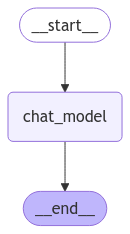

In [15]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Nodes are units of work that can be executed in a graph(python functions)

# Always start by defining a state
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}


# Edge is a connection between nodes
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you like AI?
================================ Human Message =================================
Name: Aditya

Yes I love AI , but how to learn more about it,please give me a roadmap?
================================== Ai Message ==================================

Learning AI is a journey, not a sprint.  Here's a roadmap, broken down into stages, catering to different learning styles and goals:

**Stage 1: Foundational Knowledge (1-3 months)**

* **Mathematics:**
    * **Linear Algebra:** Vectors, matrices, operations, eigenvalues, eigenvectors.  Crucial for understanding neural networks and many algorithms. Resources: Khan Academy, 3Blue1Brown (YouTube).
    * **Calculus:** Derivatives, gradients, integrals.  Essential for optimization algorithms used in training AI models. Resources: Khan Academy, MIT OpenCourseware.
    * **Probability and Statistics:** Probability distributions, hypothesis 

Points if we pass the entire conversation

1.High cost

2.High latency

3.High token usage



# Filtering the messages

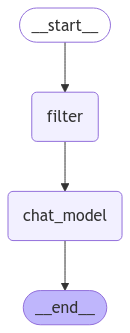

In [17]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    #This function takes the current state of messages and creates a list of RemoveMessage objects for all messages except the last two.

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching about AI?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about AI. But what other topics should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching about AI?
================================ Human Message =================================
Name: Lance

Yes, I know about AI. But what other topics should I learn about?
================================== Ai Message ==================================

That depends heavily on *why* you're researching AI.  To give you the best recommendations, I need some more context.  For example:

* **What is your current level of AI knowledge?** (Beginner, intermediate, advanced?)
* **What are your goals for learning about AI?** (For a job, a hobby, general knowledge, a specific project?)
* **What aspects of AI are you most interested in?** (Machine learning, natural language processing, computer vision, robotics, ethics of AI, etc.?)

Once I have a better understanding of your background and goals, I can suggest relevant topics.

However, here are some general areas that compl

# Trimming the messages

# Trimming happens at tokens level


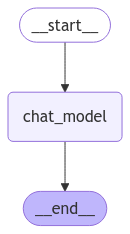

In [21]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=llm,
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching about AI?
================================ Human Message =================================
Name: Lance

Yes, I know about AI. But what other topics should I learn about?
================================== Ai Message ==================================

That depends heavily on *why* you're researching AI.  To give you the best recommendations, I need some more context.  For example:

* **What is your current level of AI knowledge?** (Beginner, intermediate, advanced?)
* **What are your goals for learning about AI?** (For a job, a hobby, general knowledge, a specific project?)
* **What aspects of AI are you most interested in?** (Machine learning, natural language processing,

In [23]:
list_of_messages=[
    ("user", "Hi, I'm Aditya"),
    ("bot", "Hi Aditya, I'm a chatbot. How can I help you today?"),
    ("user", "I'm looking for a job. Can you help me find one?"),
    ("bot", "Sure, I can help you with that. What kind of job are you looking for?"),
    ("user", "I'm looking for a job in the tech industry."),
    ("bot", "Great! What kind of tech industry are you interested in?"),
    ("user", "I'm interested in the AI industry."),
    ("bot", "Awesome! What kind of AI are you interested in?"),
    ("user", "I'm interested in AI agents."),
    ("bot", "That's great! What kind of AI agents are you interested in?"),
]



In [24]:
for i in list_of_messages:
    print(i)


('user', "Hi, I'm Aditya")
('bot', "Hi Aditya, I'm a chatbot. How can I help you today?")
('user', "I'm looking for a job. Can you help me find one?")
('bot', 'Sure, I can help you with that. What kind of job are you looking for?')
('user', "I'm looking for a job in the tech industry.")
('bot', 'Great! What kind of tech industry are you interested in?')
('user', "I'm interested in the AI industry.")
('bot', 'Awesome! What kind of AI are you interested in?')
('user', "I'm interested in AI agents.")
('bot', "That's great! What kind of AI agents are you interested in?")


In [30]:
list_of_messages [-3:]



[('bot', 'Awesome! What kind of AI are you interested in?'),
 ('user', "I'm interested in AI agents."),
 ('bot', "That's great! What kind of AI agents are you interested in?")]